In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import teotil3 as teo
from IPython.display import Image, display
from sklearn.metrics import r2_score

plt.style.use("ggplot")

In [2]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Improving suspended sediment coefficients in TEOTIL3

## Notebook 07: Simulate observations

This notebooks uses TEOTIL3 with updated loss and retention coefficients for SS to estimate SS fluxes for all sites in the combined NVE and Vannmiljø dataset. The aim is to see whether the new model is capable of recreating observed fluxes.

## 1. Filter data

In [3]:
# Choose whether to use just NVE data, just Vannmiljø data, or both
# Must be one of ('nve', 'vannmiljø', 'both')
use_data = "both"

# Number of distinct months that must be sampled each year for a station-year
# to be included e.g. if n_months_per_yr = 12, a station must have at least one
# sample per month for a station-year to be kept in the dataset
n_months_per_yr = 6

# Maximum size of catchments (in km2)
upstr_area_thresh = 10000

# Maximum percentage of catchment area that is 'lake'
lake_pct_thresh = 100

# Maximum percentage of catchment area that is ('urban' + 'agri')
anthrop_pct_thresh = 100

In [4]:
# Read data
dir_path = r"/home/jovyan/shared/common/teotil3/nve_ss_data"
cat_gdf = gpd.read_file(os.path.join(dir_path, "filtered_catchments.gpkg"))
flux_df = pd.read_csv(os.path.join(dir_path, "ss_fluxes.csv"))
q_df = pd.read_csv(os.path.join(dir_path, "flows_gts-api.csv"))
wc_df = pd.read_csv(os.path.join(dir_path, "chem_no_outliers.csv"))
q_df["date"] = pd.to_datetime(q_df["date"])
wc_df["date"] = pd.to_datetime(wc_df["date"])

# Calculate annual flows
q_df["year"] = q_df["date"].dt.year
q_df["flow_m3"] = q_df["flow_m3/s"] * 24 * 60 * 60
del q_df["date"], q_df["flow_m3/s"]
q_df = q_df.groupby(["station_id", "year"]).sum().reset_index()

# Filter data based on catchment properties
filter_str = (
    f"(area_km2 <= {upstr_area_thresh}) and "
    f"(a_lake_pct <= {lake_pct_thresh}) and "
    f"(a_anthrop_pct <= {anthrop_pct_thresh})"
)
if use_data == "nve":
    filter_str += " and (source == 'NVE')"
elif use_data == "vannmiljø":
    filter_str += " and (source == 'Vannmiljø')"
else:
    pass
cat_gdf = cat_gdf.query(filter_str)
cat_stn_list = set(cat_gdf["station_id"].unique())

# Filter based on availability of flux estimates
flux_stn_list = set(flux_df["station_id"].unique())

# Get stations meeting all criteria
stn_list = list(cat_stn_list & flux_stn_list)

# Filter to stations of interest
cat_gdf = cat_gdf.query("station_id in @stn_list")
flux_df = flux_df.query("station_id in @stn_list")
q_df = q_df.query("station_id in @stn_list")

# Filter based on sampling frequency
wc_df = wc_df.query("station_id in @stn_list")
wc_df["year"] = wc_df["date"].dt.year
wc_df["month"] = wc_df["date"].dt.month
wc_df = wc_df.groupby(["station_id", "year"]).filter(
    lambda x: x["month"].nunique() >= n_months_per_yr
)
stn_yr_df = wc_df[["station_id", "year"]].drop_duplicates()
samp_stn_list = set(stn_yr_df["station_id"].unique())
q_df = pd.merge(stn_yr_df, q_df, how="inner", on=["station_id", "year"])
flux_df = pd.merge(stn_yr_df, flux_df, how="inner", on=["station_id", "year"])
stn_list = list(set(stn_list) & samp_stn_list)
cat_gdf = cat_gdf.query("station_id in @stn_list")
wc_df = wc_df.query("station_id in @stn_list")

# Combine datasets
df = pd.merge(flux_df, q_df, how="inner", on=["station_id", "year"])
df = pd.merge(df, cat_gdf, how="left", on="station_id").drop(columns="geometry")

print(f"Data from {len(stn_list)} stations and {len(df)} station-years in the dataset.")

nivapy.spatial.quickmap(
    df, lon_col="lon", lat_col="lat", popup="station_id", cluster=True
)

Data from 770 stations and 3359 station-years in the dataset.


## 2. Link observations to TEOTIL3 results

In [5]:
# Read model data
eval_fold = r"/home/jovyan/shared/common/teotil3/evaluation"
mod_csv = os.path.join(
    eval_fold,
    "test_new_ss_coeffs",
    f"teo3_results_nve2024_2013-2023_agri-annual-loss.csv",
)
mod_df = pd.read_csv(mod_csv)

# Assign monitoring stations to regines
reg_gdf = teo.io.get_regine_geodataframe(eng, 2023)
cat_gdf = nivapy.spatial.identify_point_in_polygon(
    cat_gdf,
    reg_gdf,
    pt_col="station_id",
    poly_col="regine",
    lat_col="lat",
    lon_col="lon",
)
cat_gdf = pd.merge(
    cat_gdf,
    mod_df[["regine", "accum_upstr_area_km2"]].drop_duplicates(),
    how="left",
    on="regine",
)

# Only compare catchments where the regine upstream area is similar to the area
# upstream of the monitoring site
cat_gdf["area_diff_pct"] = (
    100 * (cat_gdf["area_km2"] - cat_gdf["accum_upstr_area_km2"]) / cat_gdf["area_km2"]
).abs()
cat_gdf = cat_gdf.query("area_diff_pct < 1")
stn_list = list(cat_gdf["station_id"].unique())
flux_df = flux_df.query("station_id in @stn_list")
flux_df = pd.merge(
    flux_df, cat_gdf[["station_id", "regine"]], how="left", on="station_id"
)

# Get total modelled SS
ss_cols = [
    col for col in mod_df.columns if col.endswith("ss_kg") and col.startswith("accum_")
]
mod_df["SS_mod_kg"] = mod_df[ss_cols].sum(axis="columns")

# Join to obs
comp_df = pd.merge(
    flux_df, mod_df[["regine", "year", "SS_mod_kg"]], how="left", on=["regine", "year"]
).dropna()
comp_df.head()

station_id  year         SS_kg    regine     SS_mod_kg
0  001-27969  2014  1.883791e+06  001.K110  2.500296e+06
1  001-27969  2015  1.413778e+06  001.K110  2.241438e+06
2  001-27969  2016  9.120417e+05  001.K110  1.420977e+06
3  001-27969  2017  9.813875e+05  001.K110  1.316818e+06
4  001-27969  2018  1.032265e+06  001.K110  1.715555e+06

R2 on logged values: 0.59.


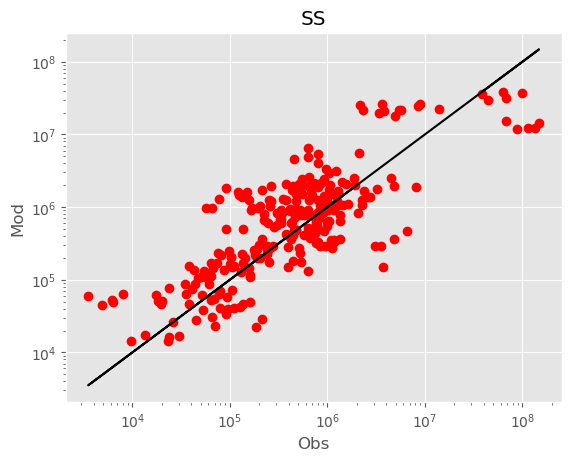

In [6]:
r2 = r2_score(np.log10(comp_df["SS_kg"]), np.log10(comp_df["SS_mod_kg"]))
print(f"R2 on logged values: {r2:.2f}.")

# Plot
plt.plot(comp_df["SS_kg"], comp_df["SS_mod_kg"], "ro")
plt.plot(comp_df["SS_kg"], comp_df["SS_kg"], "k-")
plt.xlabel("Obs")
plt.ylabel("Mod")
plt.xscale("log")
plt.yscale("log")
plt.title("SS");

In addition, the notebook `copy_T2-15b_compare_measured_fluxes.ipynb` (copied from previous development work) shows the updated performance of the model for SS. The plots below are output from this notebook and can be compared to Figs. 20 and 24 in the TEOTIL3 report. 

**In general, performance for SS seems better than before. However, I suspect river retention may be more important for SS than for the other parameters. This is omitted entirely by TEOTIL3, which may lead to overestimation of SS fluxes in large catchments with few significant lakes.**

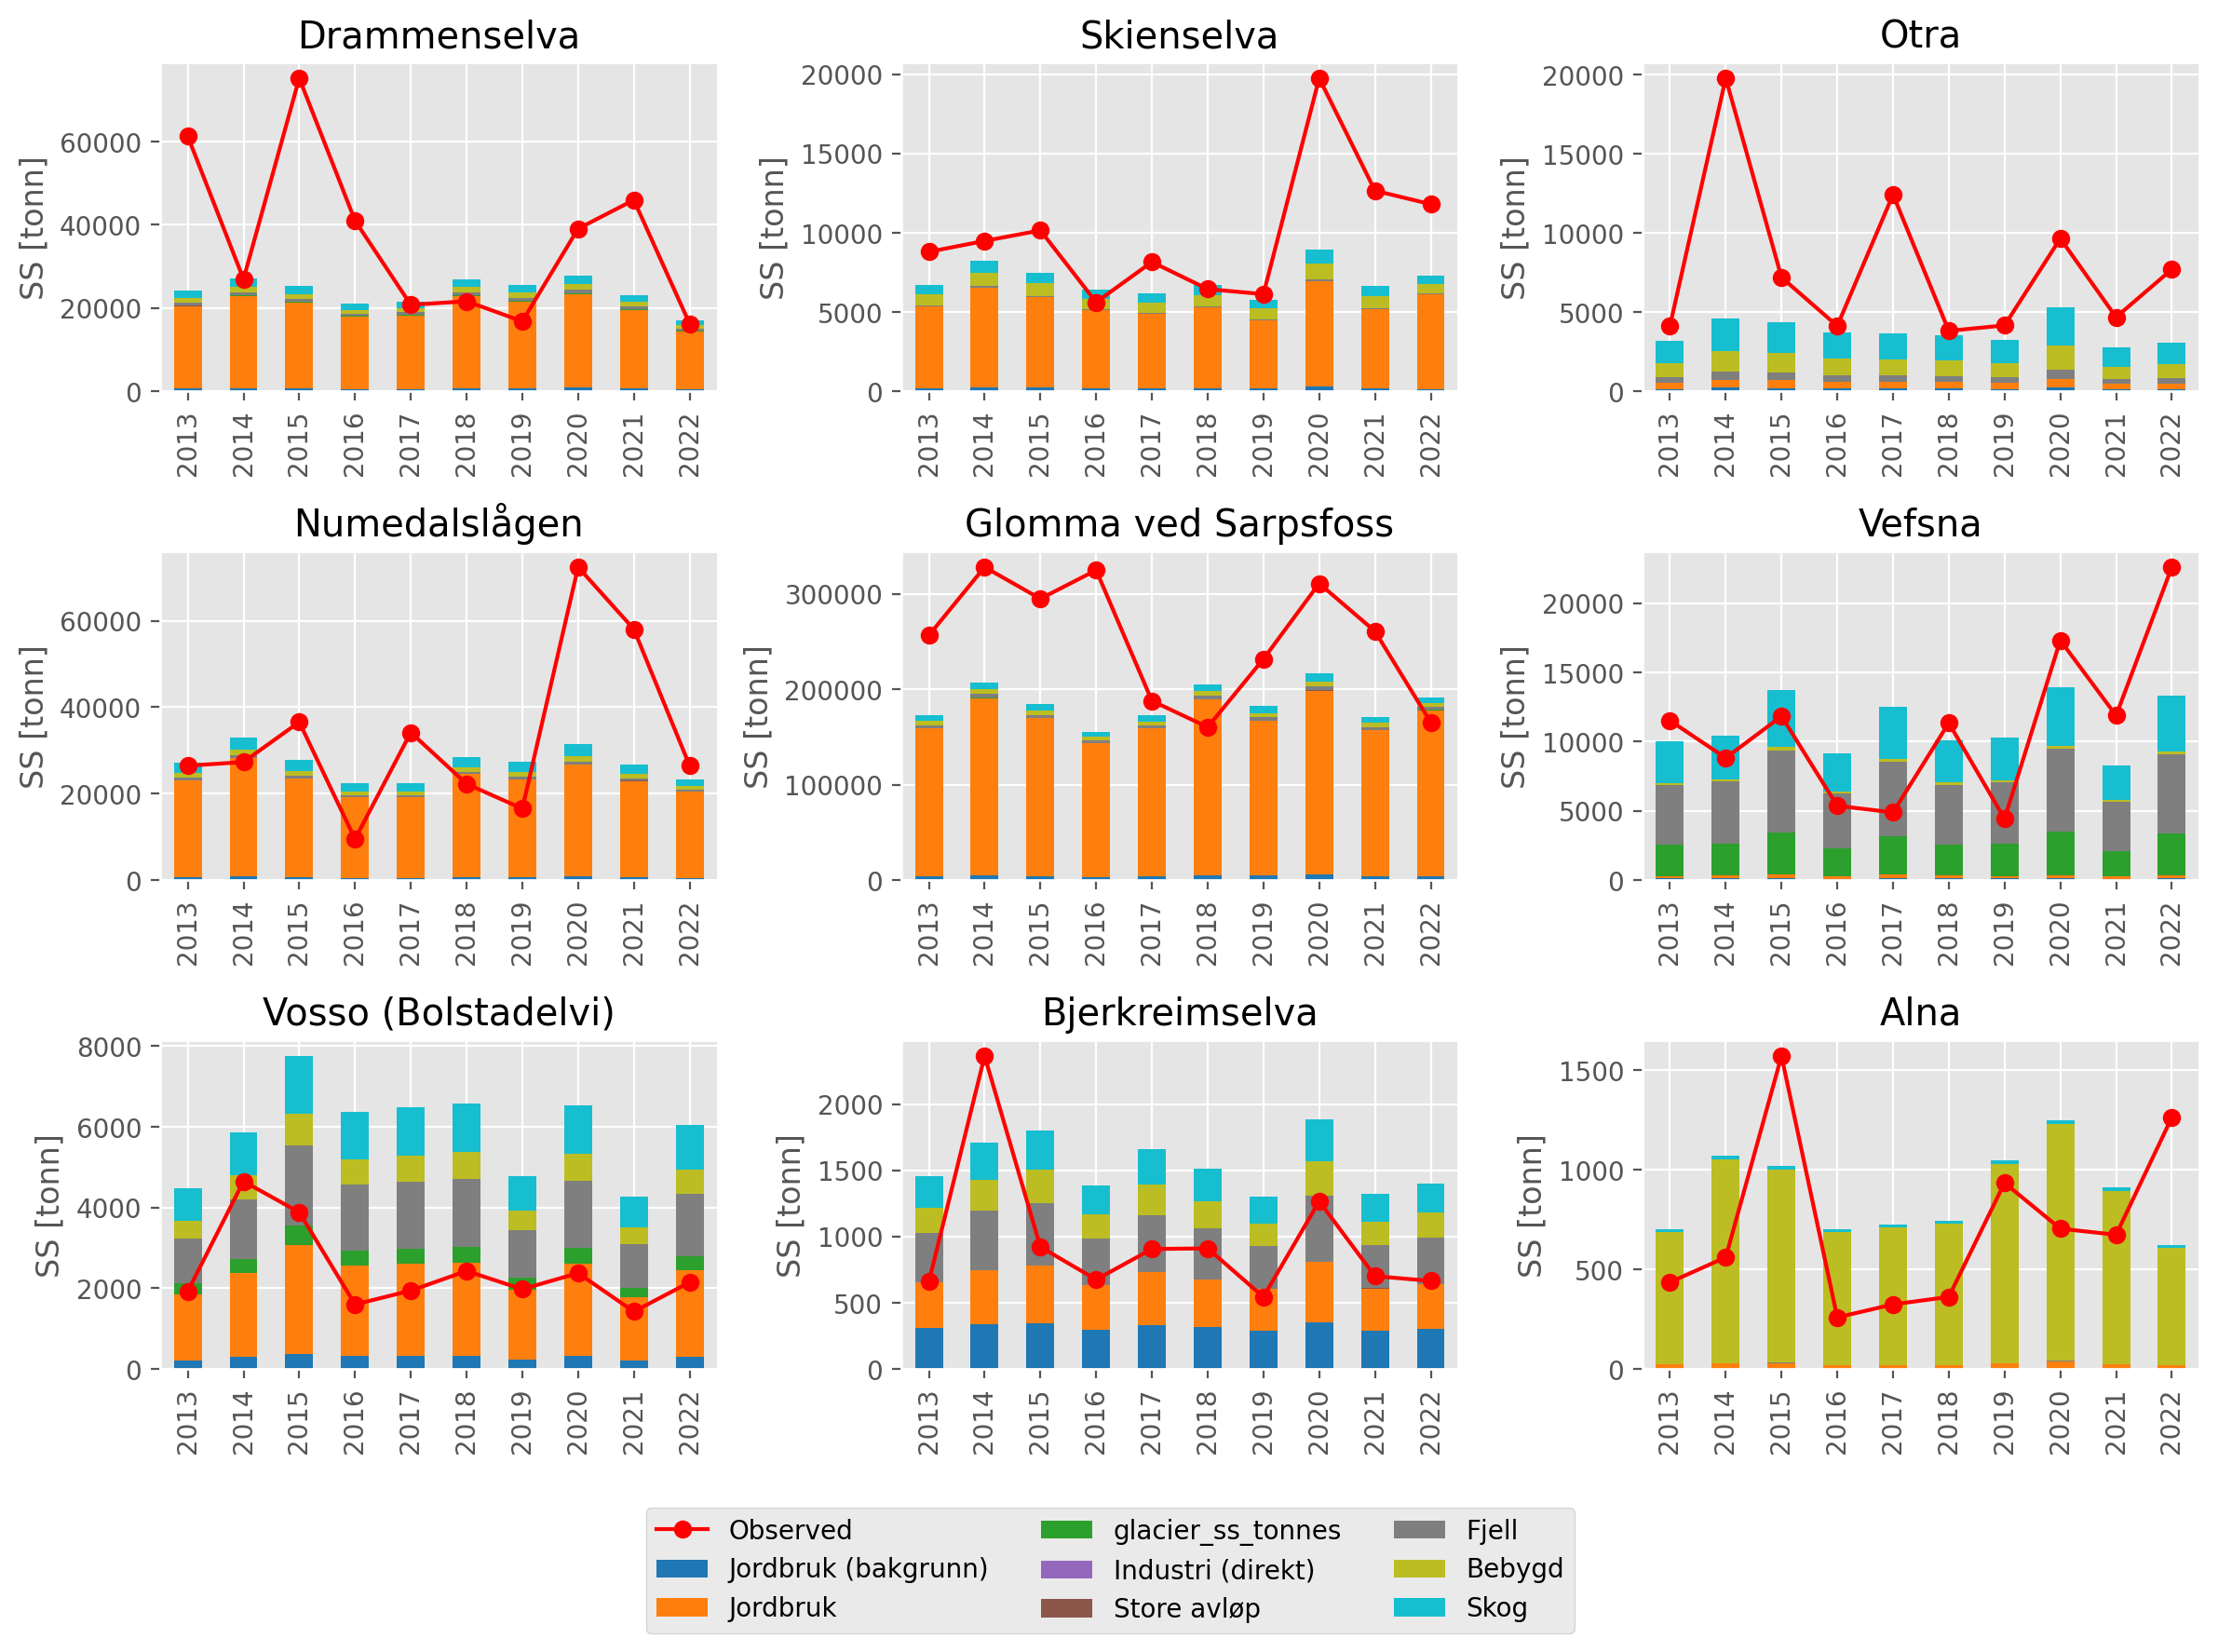

In [7]:
display(Image(filename='updated_eval_bar_charts_ss.png'))

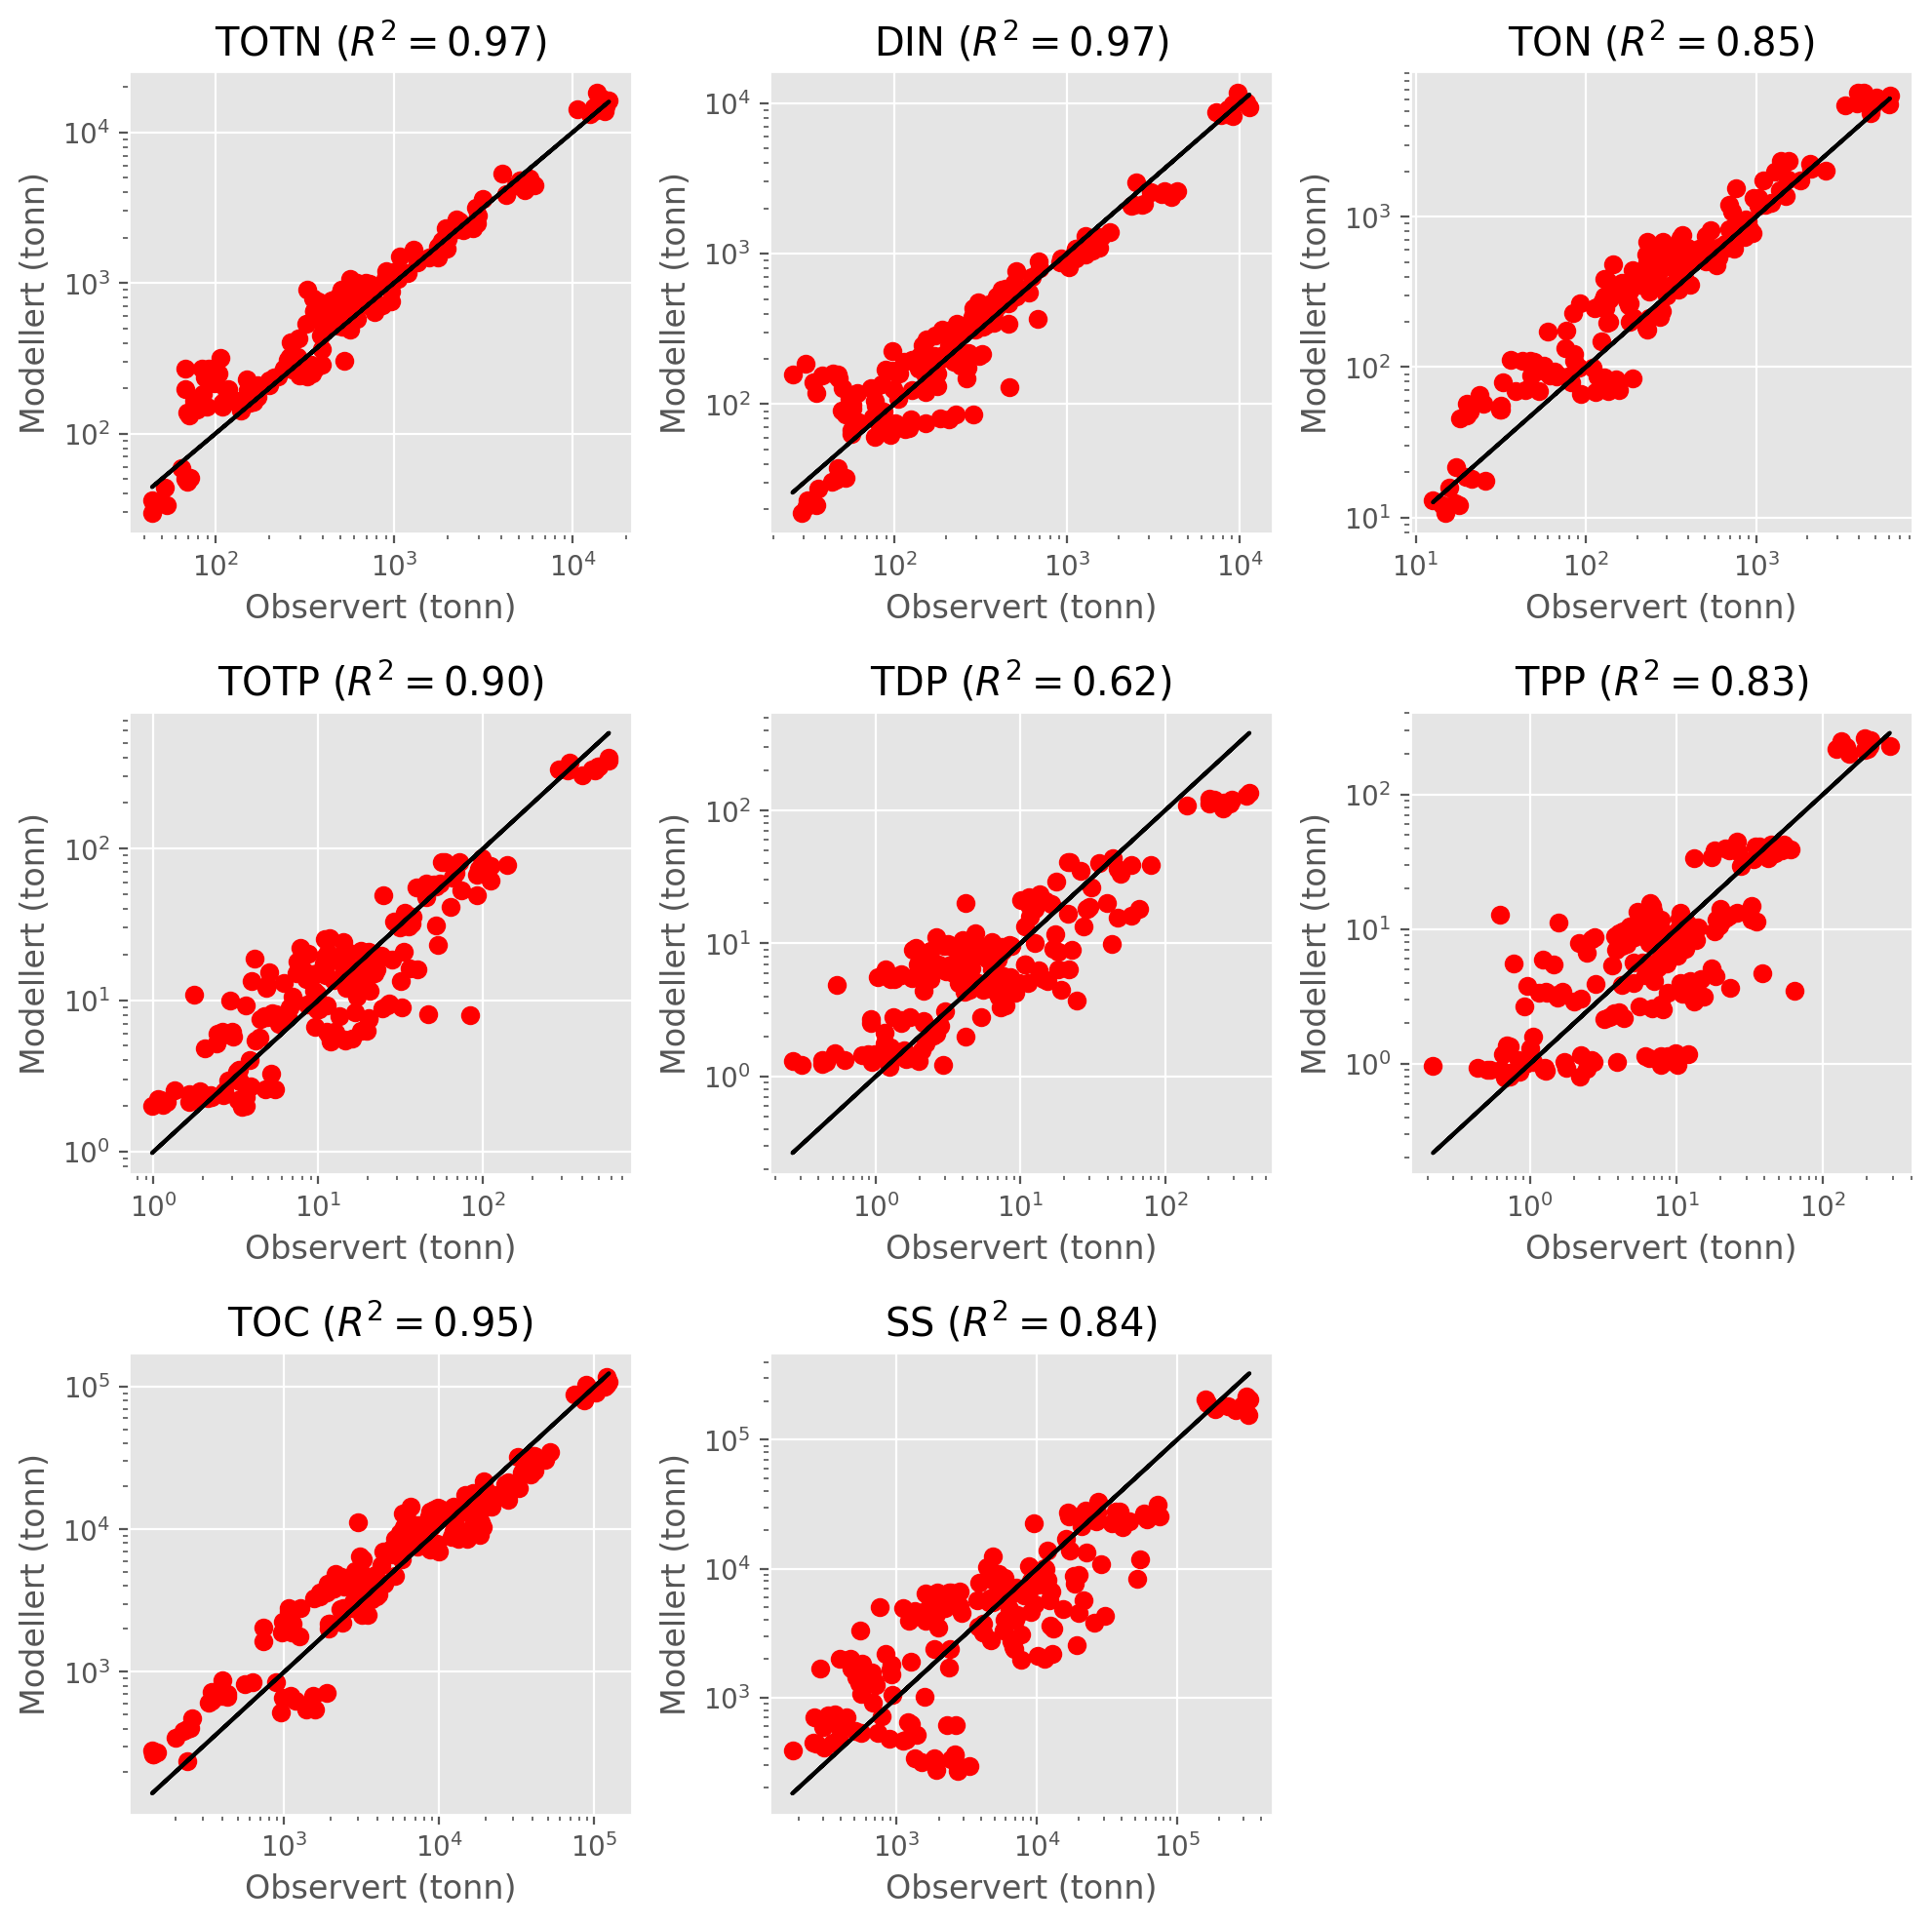

In [8]:
display(Image(filename='updated_calibrated_performance_logged.png'))